In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics
import warnings
from copy import deepcopy
from random import randrange
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

keplerDF = pd.read_csv('Kepler_Data_Final_Project.csv')
print(keplerDF.head(5))
print(keplerDF.shape)

   koi_period  koi_time0bk  koi_impact  koi_duration  koi_depth  koi_prad  \
0    9.488036   170.538750       0.146       2.95750      616.0      2.26   
1   54.418383   162.513840       0.586       4.50700      875.0      2.83   
2   19.899140   175.850252       0.969       1.78220    10800.0     14.60   
3    1.736952   170.307565       1.276       2.40641     8080.0     33.46   
4    2.525592   171.595550       0.701       1.65450      603.0      2.75   

   koi_incl  koi_teq  koi_model_snr koi_disposition  koi_steff  koi_slogg  \
0     89.66    793.0           35.8       CONFIRMED     5455.0      4.467   
1     89.57    443.0           25.8       CONFIRMED     5455.0      4.467   
2     88.96    638.0           76.3       CANDIDATE     5853.0      4.544   
3     67.09   1395.0          505.6  FALSE POSITIVE     5805.0      4.564   
4     85.41   1406.0           40.9       CONFIRMED     6031.0      4.438   

   koi_smet  koi_srad  koi_smass  
0      0.14     0.927      0.919  
1   

## Data Preprocessing

The koi_disposition will be the target vector. However, it cannot be used as it is now, since it contains non-numerical data. Here I will convert every instance of "CONFIRMED" to the binary value of 1, and the "FALSE POSITIVE" to -1.

In [2]:
keplerDF.loc[keplerDF['koi_disposition'] == 'CONFIRMED', ['koi_disposition']] = 1
keplerDF.loc[keplerDF['koi_disposition'] == 'FALSE POSITIVE', ['koi_disposition']] = 0
print(keplerDF.shape)

(9564, 15)


While most of the planets have either been confirmed or labeled false positive, some are still pending, and labeled as "CANDIDATE". As such, those rows that contain potential planets whos final status are still unknown, will be removed.

In [3]:
keplerDF.drop(keplerDF[keplerDF['koi_disposition'] == 'CANDIDATE'].index, inplace = True)
print(keplerDF.shape)

(7198, 15)


Remove missing values

In [4]:
keplerDF.dropna(inplace = True)
print(keplerDF.shape)

(6919, 15)


An addition, the properties of the host star must be split off from the planetary transit data. The steller properties will be used later for clustering

In [5]:
#keplerDF.columns = keplerDF.iloc[0]
#keplerDF = keplerDF[1:]
stellarDF = keplerDF.iloc[:,-5:]
planetaryDF = keplerDF.iloc[:,:-5]
print(planetaryDF.head(5))
print(planetaryDF.shape) #Planetary data shown below

   koi_period  koi_time0bk  koi_impact  koi_duration  koi_depth  koi_prad  \
0    9.488036   170.538750       0.146       2.95750      616.0      2.26   
1   54.418383   162.513840       0.586       4.50700      875.0      2.83   
3    1.736952   170.307565       1.276       2.40641     8080.0     33.46   
4    2.525592   171.595550       0.701       1.65450      603.0      2.75   
5   11.094321   171.201160       0.538       4.59450     1520.0      3.90   

   koi_incl  koi_teq  koi_model_snr koi_disposition  
0     89.66    793.0           35.8               1  
1     89.57    443.0           25.8               1  
3     67.09   1395.0          505.6               0  
4     85.41   1406.0           40.9               1  
5     88.11    835.0           66.5               1  
(6919, 10)


In [6]:
print(stellarDF.head(5))
print(stellarDF.shape) #Stellar data shown below

   koi_steff  koi_slogg  koi_smet  koi_srad  koi_smass
0     5455.0      4.467      0.14     0.927      0.919
1     5455.0      4.467      0.14     0.927      0.919
3     5805.0      4.564     -0.52     0.791      0.836
4     6031.0      4.438      0.07     1.046      1.095
5     6046.0      4.486     -0.08     0.972      1.053
(6919, 5)


In [7]:
#planetaryDF = shuffle(planetaryDF)
Y = planetaryDF.loc[:, 'koi_disposition'] #splitting the data into features and target vector
X_Planetary = planetaryDF.loc[:, :'koi_model_snr']
print("Shape of target vector:", Y.shape)
print("Shape of features:", X_Planetary.shape)

Shape of target vector: (6919,)
Shape of features: (6919, 9)


# Linear Support Vector Machine
### Standardization and splitting the dataset
Given the wide spread in the range of our features, in addition to the difference in measurement units, it is necessary to standardize them, so that the mere magnitude of a particular feature will not dominate the rest.

In [8]:
scaler = StandardScaler()
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Planetary, Y, test_size = 0.30)
SVM_classifier = LinearSVC(C = 1, loss = "hinge", max_iter = 1000000)
scaledSVM = Pipeline([("scaler", scaler), ("linearClassifier", SVM_classifier)])

## Training and Testing the Soft SVM

In [9]:
Y_Train = Y_Train.astype('int64') #The values must be of the same type (in this case type 'int'), otherwise, this model will not run
print(Y_Train.shape)
scaledSVM.fit(X_Train, Y_Train.values.ravel())

(4843,)


Pipeline(steps=[('scaler', StandardScaler()),
                ('linearClassifier',
                 LinearSVC(C=1, loss='hinge', max_iter=1000000))])

In [10]:
predictedValues = scaledSVM.predict(X_Test)
Y_Test = Y_Test.astype('int64')
print("Confusion Matrix: ")
print(confusion_matrix(Y_Test, predictedValues))
print()
print("Accuracy:", "{:.2%}".format(accuracy_score(Y_Test, predictedValues)))
print("F1 score:", "{:.2%}".format(f1_score(Y_Test, predictedValues)))

Confusion Matrix: 
[[1150  251]
 [ 111  564]]

Accuracy: 82.56%
F1 score: 75.70%


## Finding Optimal C for Soft-margin SVM
Given the classificaton report, it is clear that C, the penalty parameter, is not adequate. This parameter is used as a trade-off value between misclassifications and the margin size. The smaller the value of C, the larger the tolerance for misclassification, resulting in a larger margin. The higher the C, the lesser the tolerance for misclassification, resulting in a smaller margin. Therefore, a higher C brings the model closer to a 'hard' SVM. Therefore, C will be the hyperparameter that will be tuned

In [11]:
C_list = [(i*2)+1 for i in range(35)]
X_Train = scaler.fit_transform(X_Train)
X_Test = scaler.fit_transform(X_Test)
tuned_parameters = [{'max_iter': [1000000], 'loss':['hinge'], 'C': C_list}]

print("Tuning hyper-parameters for accuracy")
print()
linearSVM = GridSearchCV(LinearSVC(), tuned_parameters, scoring = 'accuracy')
linearSVM.fit(X_Train, Y_Train)

print("Best parameters set found on development set:")
print()
print(linearSVM.best_params_)
print()
print("Grid scores on development set:")
print()
means = linearSVM.cv_results_['mean_test_score']
stds = linearSVM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, linearSVM.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
actualValues, predictedValues = Y_Test, linearSVM.predict(X_Test)
print(classification_report(actualValues, predictedValues))
print()

Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 55, 'loss': 'hinge', 'max_iter': 1000000}

Grid scores on development set:

0.829 (+/-0.023) for {'C': 1, 'loss': 'hinge', 'max_iter': 1000000}
0.832 (+/-0.023) for {'C': 3, 'loss': 'hinge', 'max_iter': 1000000}
0.833 (+/-0.021) for {'C': 5, 'loss': 'hinge', 'max_iter': 1000000}
0.834 (+/-0.020) for {'C': 7, 'loss': 'hinge', 'max_iter': 1000000}
0.835 (+/-0.020) for {'C': 9, 'loss': 'hinge', 'max_iter': 1000000}
0.836 (+/-0.021) for {'C': 11, 'loss': 'hinge', 'max_iter': 1000000}
0.836 (+/-0.022) for {'C': 13, 'loss': 'hinge', 'max_iter': 1000000}
0.836 (+/-0.023) for {'C': 15, 'loss': 'hinge', 'max_iter': 1000000}
0.837 (+/-0.023) for {'C': 17, 'loss': 'hinge', 'max_iter': 1000000}
0.838 (+/-0.021) for {'C': 19, 'loss': 'hinge', 'max_iter': 1000000}
0.837 (+/-0.022) for {'C': 21, 'loss': 'hinge', 'max_iter': 1000000}
0.838 (+/-0.022) for {'C': 23, 'loss': 'hinge', 'max_iter': 1000000}
0.837 (+/-

In [12]:
linearSVM = LinearSVC(C = 55, loss = "hinge", max_iter = 1000000)
linearSVM.fit(X_Train, Y_Train.values.ravel())
predictedValues = linearSVM.predict(X_Test)
print("Confusion Matrix: ")
print(confusion_matrix(Y_Test, predictedValues))
print()
print("Accuracy:", "{:.2%}".format(accuracy_score(Y_Test, predictedValues)))
print("F1 score:", "{:.2%}".format(f1_score(Y_Test, predictedValues)))

Confusion Matrix: 
[[1257  144]
 [ 231  444]]

Accuracy: 81.94%
F1 score: 70.31%


# Kernalized Support Vector Machine

## Polynomial Kernel
### Hyperparameter Tuning (GridSearchCV)
To elevate the samples into a higher-dimension, the polynomial kernelized SVM uses a polynomial function of N-degree. In this optimization, several values of d will be used

In [46]:
X_Train = scaler.fit_transform(X_Train)
X_Test = scaler.fit_transform(X_Test)
tuned_parameters = [{'kernel': ['poly'], 'degree': [1,2,3,4,5], 'C': [(i*2)+1 for i in range(30)], 'gamma': ['auto']}]

print("Tuning hyper-parameters for accuracy")
print()
polynomialSVM = GridSearchCV(SVC(), tuned_parameters, scoring = 'accuracy')
polynomialSVM.fit(X_Train, Y_Train)

print("Best parameters set found on development set:")
print()
print(polynomialSVM.best_params_)
print()
print("Grid scores on development set:")
print()
means = polynomialSVM.cv_results_['mean_test_score']
stds = polynomialSVM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, polynomialSVM.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
actualValues, predictedValues = Y_Test, polynomialSVM.predict(X_Test)
print(classification_report(actualValues, predictedValues))
print()

Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 59, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

Grid scores on development set:

0.823 (+/-0.015) for {'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
0.804 (+/-0.018) for {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
0.774 (+/-0.035) for {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
0.662 (+/-0.005) for {'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
0.662 (+/-0.008) for {'C': 1, 'degree': 5, 'gamma': 'auto', 'kernel': 'poly'}
0.827 (+/-0.017) for {'C': 3, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
0.814 (+/-0.020) for {'C': 3, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
0.815 (+/-0.026) for {'C': 3, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
0.714 (+/-0.070) for {'C': 3, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
0.662 (+/-0.011) for {'C': 3, 'degree': 5, 'gamma': 'auto', 'kernel': 'poly'}
0.829 (+/-0.017) for {'C': 5, 'degree': 1, 

In [50]:
print('Model is training...')

polynomialSVM = SVC(C=59, kernel='poly', degree = 3, gamma='auto')
polynomialSVM.fit(X_Train, Y_Train)
predictedValues = polynomialSVM.predict(X_Test)

print('Training complete')    
print(confusion_matrix(Y_Test, predictedValues))
print(classification_report(Y_Test, predictedValues))
print("Accuracy score:", "{:.2%}".format(accuracy_score(Y_Test, predictedValues)))
print("F1 score: ", "{:.2%}".format(f1_score(Y_Test, predictedValues)))

Model is training...
Training complete
[[1189  164]
 [ 175  548]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1353
           1       0.77      0.76      0.76       723

    accuracy                           0.84      2076
   macro avg       0.82      0.82      0.82      2076
weighted avg       0.84      0.84      0.84      2076

Accuracy score: 83.67%
F1 score:  76.38%


## Radial Basis Function

### Hyperparameter Tuning (GridSearchCV)

For the RBF Kernalized SVM, there are two hyperparameters to optimize: gamma, and C. Gamma, the new term, defines how much influence a support vector has on the model. If gamma is low, this means the 'sphere' of influence of that sample will be significant, whereas if it's high, the sphere of influence will be smaller.

In [15]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-5, 1e-6, 1e-7],
                     'C': [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]}]
scores = ['accuracy', 'f1']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    if score == 'accuracy':
        RBF_SVM = GridSearchCV(SVC(), tuned_parameters, scoring = 'accuracy')
    else:
        RBF_SVM = GridSearchCV(SVC(), tuned_parameters, scoring = '%s_macro' % score)          
    RBF_SVM.fit(X_Train, Y_Train)

    print("Best parameters set found on development set:")
    print()
    print(RBF_SVM.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = RBF_SVM.cv_results_['mean_test_score']
    stds = RBF_SVM.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, RBF_SVM.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Classification report:")
    print()
    actualValues, predictedValues = Y_Test, RBF_SVM.predict(X_Test)
    print(classification_report(actualValues, predictedValues))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 100000000.0, 'gamma': 1e-05, 'kernel': 'rbf'}

Grid scores on development set:

0.779 (+/-0.021) for {'C': 100.0, 'gamma': 1e-05, 'kernel': 'rbf'}
0.653 (+/-0.001) for {'C': 100.0, 'gamma': 1e-06, 'kernel': 'rbf'}
0.653 (+/-0.001) for {'C': 100.0, 'gamma': 1e-07, 'kernel': 'rbf'}
0.817 (+/-0.015) for {'C': 1000.0, 'gamma': 1e-05, 'kernel': 'rbf'}
0.779 (+/-0.021) for {'C': 1000.0, 'gamma': 1e-06, 'kernel': 'rbf'}
0.653 (+/-0.001) for {'C': 1000.0, 'gamma': 1e-07, 'kernel': 'rbf'}
0.824 (+/-0.017) for {'C': 10000.0, 'gamma': 1e-05, 'kernel': 'rbf'}
0.817 (+/-0.015) for {'C': 10000.0, 'gamma': 1e-06, 'kernel': 'rbf'}
0.778 (+/-0.020) for {'C': 10000.0, 'gamma': 1e-07, 'kernel': 'rbf'}
0.832 (+/-0.024) for {'C': 100000.0, 'gamma': 1e-05, 'kernel': 'rbf'}
0.824 (+/-0.018) for {'C': 100000.0, 'gamma': 1e-06, 'kernel': 'rbf'}
0.817 (+/-0.016) for {'C': 100000.0, 'gamma': 1e-07, 'kernel': 'rbf'}
0.838

In [16]:
RBF_SVM = SVC(kernel="rbf", gamma= 1e-5, C=1e8)
RBF_SVM.fit(X_Train, Y_Train)
predictedValues = RBF_SVM.predict(X_Test)
print("Confusion Matrix: ")
print(confusion_matrix(Y_Test, predictedValues))
print()
print("Accuracy score:", "{:.2%}".format(accuracy_score(Y_Test, predictedValues)))
print("F1 score: ", "{:.2%}".format(f1_score(Y_Test, predictedValues)))

Confusion Matrix: 
[[1245  156]
 [ 188  487]]

Accuracy score: 83.43%
F1 score:  73.90%


# K-Means Clustering

In [19]:
stellarDF = pd.concat([stellarDF, Y], axis = 1)
print(stellarDF)

      koi_steff  koi_slogg  koi_smet  koi_srad  koi_smass koi_disposition
0        5455.0      4.467      0.14     0.927      0.919               1
1        5455.0      4.467      0.14     0.927      0.919               1
3        5805.0      4.564     -0.52     0.791      0.836               0
4        6031.0      4.438      0.07     1.046      1.095               1
5        6046.0      4.486     -0.08     0.972      1.053               1
...         ...        ...       ...       ...        ...             ...
9557     5263.0      4.574     -0.66     0.699      0.668               0
9558     5638.0      4.296     -0.16     1.088      0.856               0
9559     5638.0      4.529      0.14     0.903      1.005               0
9561     6173.0      4.447     -0.04     1.041      1.104               0
9563     6469.0      4.385      0.07     1.193      1.260               0

[6919 rows x 6 columns]


Remove rows that have 'false positive' labeling for planets. Will only keep stars that are confirmed to have planets around them

In [20]:
stellarDF.drop(stellarDF[stellarDF['koi_disposition'] == 0].index, inplace = True)
print(stellarDF)

      koi_steff  koi_slogg  koi_smet  koi_srad  koi_smass koi_disposition
0        5455.0      4.467      0.14     0.927      0.919               1
1        5455.0      4.467      0.14     0.927      0.919               1
4        6031.0      4.438      0.07     1.046      1.095               1
5        6046.0      4.486     -0.08     0.972      1.053               1
6        6046.0      4.486     -0.08     0.972      1.053               1
...         ...        ...       ...       ...        ...             ...
7658     5970.0      4.317      0.10     1.200      1.089               1
8817     3236.0      5.097      0.00     0.193      0.169               1
8956     3327.0      5.113     -0.38     0.189      0.169               1
9014     5579.0      4.580     -0.22     0.798      0.892               1
9083     5713.0      4.541      0.07     0.893      1.010               1

[2357 rows x 6 columns]


<function matplotlib.pyplot.show(*args, **kw)>

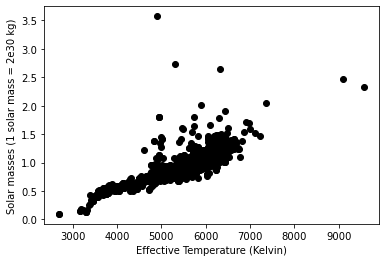

In [21]:
plt.scatter(stellarDF['koi_steff'], stellarDF['koi_smass'], color = 'black')
plt.ylabel("Solar masses (1 solar mass = 2e30 kg)")
plt.xlabel("Effective Temperature (Kelvin)")
plt.show

In [22]:
stellarStandard = MinMaxScaler().fit_transform(stellarDF)
stellarStandard = np.delete(stellarStandard, -1, axis=1)

In [24]:
def euclideanDistance(point1, point2):
    distance = 0
    for j in range(5):
        distance += (point1[j] - point2[j])**2
    return math.sqrt(distance)

class K_Means_Clustering:
    def __init__(self, k, maxIterations):
        self.k = k
        self.maxIter = maxIterations
        self.currentIteration = 0
     
    #This updates the centroids by having their 5-dimensional coordinates equal the mean of each column
    #As an example, for centroid #1, it's 0th coordinate will equal the mean of the zeroth column of it's samples, 
    #it's 1st coordinate will equal the mean of the 1st column, etc. It will do this for each coordinate, for every centroid
    def updateCentroids(self):
        index = 0
        self.oldCentroids = deepcopy(self.centroids)
        for key in self.classes:
            if self.k == 1:
                self.centroids = np.mean(self.classes[key], axis = 1)
            else:
                self.centroids[index] = np.mean(self.classes[key], axis = 0)
                index += 1
    
    #This classifies each row of the feature matrix, self-explanatory            
    def classifyRow(self, row):
        intermediate = self.findDistances(self.featureMatrix[row])
        centroidDistances = self.SortTuple(intermediate)
        return centroidDistances[0]
     
    #This sorts the tuples in the array based on the first element (smallets to largest), the distance. 
    #It then returns the first element, which represents the closest centroid 
    def SortTuple(self, tupleList):
        return sorted(tupleList, key = lambda x: x[0])
    
    #This uses the distance metric to find the distance of each sample to all the centroids, and then stores the distance
    #and class in a tuple
    def findDistances(self, row):
        distanceArray = []
        if self.k == 1:
            loop = 1
        else:
            loop = self.centroids.shape[0]
        for centroid in range(loop):
            if (self.distanceMetric == "euclidean"):
                if (loop == 1):
                    distanceArray.append(tuple([euclideanDistance(row, self.centroids),str(centroid)]))
                else:
                    distanceArray.append(tuple([euclideanDistance(row, self.centroids[centroid]),str(centroid)]))
        return distanceArray
    
    #Convergence criteria
    #This calculates the mean of each centroid. If the percent difference between the previous mean and the new mean 
    #are less than 0.1%, then the algorithm will stop
    def convergence(self):
        if self.k == 1:
            oldMean = [np.mean(self.oldCentroids)]
            newMean = [np.mean(self.centroids)]
            loop = 1
        else:
            oldMean = np.mean(self.oldCentroids, axis = 1) #returns array of row means
            newMean = np.mean(self.centroids, axis = 1)
            loop = oldMean.shape[0]
        percentDifference = []
        for i in range(loop):
            percentDifference.append(abs((newMean[i] - oldMean[i])/oldMean[i]))
        if np.amax(percentDifference) <= 0.001:
            print(percentDifference)
            print("Converged at iteration:", self.currentIteration)
            return True
        else:
            return False
    
    def cluster(self, featureMatrix, distanceMetric):
        self.distanceMetric = distanceMetric
        self.featureMatrix = featureMatrix
        self.n_rows, self.n_columns = featureMatrix.shape

        #Centroid initialization
        #This will generate a matrix of k x m matrix of centroids
        self.centroids = np.array([])
        for value in range(self.k):
            randomRow = randrange(self.n_rows)
            if value == 0:
                self.centroids = np.append(self.centroids, np.copy(self.featureMatrix[randomRow]))
            else:
                self.centroids = np.vstack((self.centroids, np.copy(self.featureMatrix[randomRow])))
        
        #This dictionary object will hold each centroid as the key, and it's values will be the samples that belong to it
        #Thus, this will be a dictionary of numpy arrays
            self.classes = {}
            
        #This is the bulk of where the calculations happen    
        for iteration in range(self.maxIter):
            #if self.currentIteration%10 == 0:
                #print("Current iteration: ", self.currentIteration)
            self.classes.clear()
            for row in range(self.n_rows):
                distanceValue, starClass = self.classifyRow(row)
                if starClass in self.classes:
                    self.classes[starClass] = np.vstack((self.classes[starClass],self.featureMatrix[row]))
                else:
                    self.classes[starClass] = np.copy(self.featureMatrix[row])
            self.updateCentroids()
            if self.convergence() == True:
                return self.classes
            self.currentIteration += 1 
        return self.classes

### Hyperparameter Tuning (Elbow Method)

The elbow method is a relatively simple tuning algorithm. For K-means, the only hyperparameter that has to be tuned is "k", the number of clusters. What the elbow method does is plot the mean squared distance each sample has to it's respective centroid against the number of clusters being used. For K-means, as the number of clusters increase, the average squared distance from any sample to a cluster centroid should decrease. At first that inverse relationship is linear, but eventually, it becomes polynomial. The point where that relationship stops being linear is the "elbow".

In [25]:
clusterArray = [1,2,3,4,5,6,7,8,9,10]
def elbowMethod(clusterArray, featureMatrix, maxIter):
    inertiaMatrix = np.array([])
    for cluster in clusterArray:
        inertia = np.array([])
        print("Now on cluster: ", cluster)
        for i in range(5):
            kMeansElbow = K_Means_Clustering(cluster, maxIter)
            predictions = kMeansElbow.cluster(featureMatrix, "euclidean")
            for key in predictions:
                inertia = np.append(inertia, np.sum(np.square(predictions[key])))
        inertia = np.mean(inertia)
        inertia = np.append(inertia, cluster)
        if inertiaMatrix.size == 0:
            inertiaMatrix = np.append(inertiaMatrix, inertia)
        else:
            inertiaMatrix = np.vstack((inertiaMatrix, inertia))
    return inertiaMatrix

plotArray = elbowMethod(clusterArray, stellarStandard, 200)

Now on cluster:  1
[0.0]
Converged at iteration: 1
[0.0]
Converged at iteration: 1
[0.0]
Converged at iteration: 1
[0.0]
Converged at iteration: 1
[0.0]
Converged at iteration: 1
Now on cluster:  2
[0.00013934145346223612, 0.0008946350936014142]
Converged at iteration: 8
[4.570066217222471e-05, 0.0009591446687093574]
Converged at iteration: 7
[3.151841571159264e-05, 0.0009225114411424311]
Converged at iteration: 6
[6.28334961796227e-05, 0.00099969710134734]
Converged at iteration: 6
[0.0003838601925341419, 0.0008732531535996981]
Converged at iteration: 11
Now on cluster:  3
[0.0005461988477313067, 0.0005567658060392288, 0.0006965188451195955]
Converged at iteration: 8
[1.529577424285934e-05, 8.257754115422848e-05, 0.0004087274670446182]
Converged at iteration: 5
[0.0007380907629108355, 0.0008792873561178056, 0.0006621642797685146]
Converged at iteration: 3
[0.0003201046844499244, 0.0009500392691642447, 1.525861874310024e-05]
Converged at iteration: 7
[8.628302624620661e-06, 0.000236874

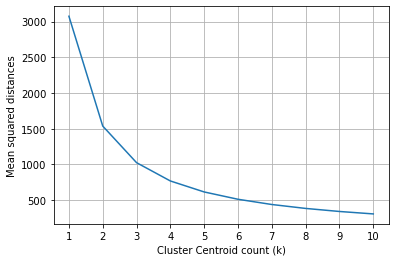

In [30]:
plt.plot(plotArray[:,1], plotArray[:,0])
plt.xticks(np.arange(min(plotArray[:,1]), max(plotArray[:,1] +1), 1.0))
plt.xlabel("Cluster Centroid count (k)")
plt.ylabel("Mean squared distances")
plt.grid()
plt.show()

The elbow for this curve is at k = 3, therefore future instances of K-Means for this dataset will use k = 3.

In [27]:
kMeans = K_Means_Clustering(3, 200)
predictedValues = kMeans.cluster(stellarStandard, "euclidean")
print("Clustering complete!")

[4.653927230778627e-05, 0.00013149124839322544, 0.0008747133894885526]
Converged at iteration: 23
Clustering complete!


In [29]:
print(predictedValues['0'].shape)
print(predictedValues['1'].shape)
print(predictedValues['2'].shape)

(1065, 5)
(894, 5)
(398, 5)
